# Measuring Aliasing
A proposal for measuring aliasing in simple non-linearities. This is based on predicting harmonics and aliased harmonics and measuring the energy ratio between them. Since there can possibly be infinite harmonics, this algorithm stops at a defineable point (the `roundTrips` variable).
A different, simpler method is to simply upsample the system and comparing the energy of the upsampled system with the non-upsampled one. A comparison between the two methods can be found below.
The proposed method basically delivers identical results and can be used for systems that can not be upsampled, for example outboard equipment or more complex systems that might react differently overall if upsampled.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample

In [2]:
def aToDb(linArray, accuracy = 10):
    dbArray = 20.*np.log10(np.clip(linArray,10**-accuracy,10**accuracy))
    return dbArray

In [3]:
def freqToBin(freqs,sr,frameSize):
    if type(freqs)==list:
        freqs=np.array(freqs)
    nyq=sr/2
    bins = (np.round((freqs / nyq) * frameSize / 2.))
    bins = bins.astype(int)
    return bins

In [4]:
def getAliased(f,sr):
    fn = sr/2
    f = np.abs(f)
    roundTrip = int(f/fn)
    oddEven = roundTrip%2
    aliased = fn*oddEven + (f%fn)*(1+(-2*oddEven))
    return aliased, roundTrip

In [5]:
def getAllAliased(f,sr,roundTrips=100):
    rts = 0
    evenFreqs = []
    oddFreqs = []
    allFreqs = []
    i = 0
    while rts <= roundTrips:
        freq = f*i
        freq,rts = getAliased(freq,sr)
        if rts>= 1:
            if i%2==0:
                evenFreqs.append(freq)
            else:
                oddFreqs.append(freq)
            allFreqs.append(freq)
        i+=1
    return allFreqs,evenFreqs,oddFreqs
    

In [6]:
def getOvertones(f,sr):
    nyq = sr/2
    No = int(np.floor(nyq/f))+1
    overtoneFreqs = [f*x for x in range(No)]
    evenOverTones = [f*x*2 for x in range(int(No/2))]
    oddOverTones = [f*((x+1)*2-1) for x in range(int(No/2))]
    return overtoneFreqs, evenOverTones,oddOverTones 

In [7]:
def getSpec(inputSignal, outputSignal,sr):
    N = len(inputSignal)
    nhalf = int(N/2)+1
    freqAxis = np.linspace(0,int(sr/2),nhalf)
    specOutput = (np.abs(np.fft.fft(outputSignal))/N)[0:nhalf]
    specInput = (np.abs(np.fft.fft(inputSignal))/N)[0:nhalf]
    return specInput, specOutput, freqAxis

In [8]:
def _analysisToAliasingRatio(overtoneFreqs,evenFreqs,oddFreqs,specOutput,sr,N, filterRegular = False, filterDuplicate=True):
    binsRegular = freqToBin(overtoneFreqs, sr,N)
    binsOdd = freqToBin(evenFreqs, sr, N)
    binsEven = freqToBin(oddFreqs, sr, N)
    
    if filterRegular:
        mask = [(x not in binsRegular) for x in binsOdd]
        binsOdd = binsOdd[mask]
        
        mask = [(x not in binsRegular) for x in binsEven]
        binsEven = binsEven[mask]
    if filterDuplicate:
        mask = [(x not in binsOdd) for x in binsEven]
        binsEven = binsEven[mask]
        
        
        

    ampOddAlias = specOutput[binsOdd].sum()
    ampEvenAlias = specOutput[binsEven].sum()
    ampRegular = specOutput[binsRegular].sum()

    aliasingRatioLin = ((ampOddAlias+ampEvenAlias)/ampRegular)

    aliasingRatio = aToDb(aliasingRatioLin)
    return aliasingRatio

In [9]:
def plotSpectrum(specInput, specOutput, evenFreqs,oddFreqs,overtoneFreqs,allOvertones, freqAxis, title='Spectrum'):

    specInputDb = aToDb(specInput)
    specOutputDb = aToDb(specOutput)

    yse = np.zeros_like(evenFreqs)-20
    yso = np.zeros_like(oddFreqs)-10
    ysReg = np.zeros_like(overtoneFreqs)

    plt.figure(figsize=[17, 5])

    plt.plot(freqAxis, specOutputDb, label='output signal')
    plt.plot(freqAxis, specInputDb, label='input Signal')

    plt.plot(evenFreqs, yse, 'rx', label='even alias Frequencies')
    plt.plot(oddFreqs, yso, 'bx', label='odd alias Frequencies')
    plt.plot(overtoneFreqs, ysReg, 'gx', label='regular overtones')
    plt.legend(loc='best')
    plt.xlabel('Frequency[Hz]')
    plt.ylabel('Amplitude[dB]')
    
    lowerBoundI = np.min(specInputDb)
    lowerBoundO = np.min(specOutputDb)
    lowerBound = min(lowerBoundI,lowerBoundO)
    
#     print(allOvertones)

    for i in range(len(allOvertones)):
        fbin = freqToBin(allOvertones[i], sr, N)
        if specOutputDb[fbin] > -200:
            plt.text(allOvertones[i], max(-2*i,lowerBound), str(i))
    plt.title(title)
    plt.grid()
    plt.show()


In [10]:
def inputOutputToAliasingRatio(fundamentalFreq, inputSignal, OutputSignal, sr, roundTrips=100, doPlot=True):
    N = len(inputSignal)
    f = fundamentalFreq
    overtoneFreqs, _, _ = getOvertones(f,sr)
    allFreqs,evenFreqs,oddFreqs = getAllAliased(f,sr,roundTrips=roundTrips)
    
    oddFreqs = np.unique(oddFreqs)
    evenFreqs = np.unique(evenFreqs)
    
    specInput, specOutput, freqAxis = getSpec(inputSignal,OutputSignal, sr)
    
    allOvertones = overtoneFreqs+allFreqs
    
    if doPlot:
        plotSpectrum(specInput, specOutput,evenFreqs,oddFreqs,overtoneFreqs,allOvertones, freqAxis, title='Harmonics Plot for %f Hz'%fundamentalFreq)
        
    aliasingRatio = _analysisToAliasingRatio(overtoneFreqs,evenFreqs,oddFreqs,specOutput,sr,N)
    return aliasingRatio
    

In [11]:
def fundamentalToAliasingRatio(f,testSystem,sr,T=3, roundTrips=10, doPlot = True):
    N = int(sr*T)
    n = np.arange(N)
    t = n/sr
    
    testSig = np.sin(2*np.pi*t*f)
    dist = testSystem(testSig)
    
    aliasingRatio = inputOutputToAliasingRatio(f,testSig,dist,sr,roundTrips=roundTrips, doPlot=doPlot)
    return aliasingRatio
    

In [12]:
def getAliasingRatioPerFreq(testFunction, sr, numTests=100, doPlot=True, roundTrips = 100):
#     numTests = 100
    freqs = np.linspace(sr/1000, sr/4, numTests)
    freqs = np.round(freqs)
    freqs = np.unique(freqs)
    
    ratios = []
    for i in range(numTests):
        aliasingRatio = fundamentalToAliasingRatio(freqs[i],testFunction,sr,doPlot=False,roundTrips = roundTrips)
        ratios.append(aliasingRatio)
    if doPlot:
        plt.plot(freqs, ratios)
        plt.grid()
        plt.xlabel('Frequency[Hz]')
        plt.ylabel('Aliasing Ratio [dB]')
        plt.title('Aliasing Ratios for: '+testFunction.__name__)
        plt.show()
        
    return ratios

In [13]:
def applyUpsampled(x, testSytem, resamplingFactor=8):
    N = len(x)
    xUpsampled = resample(x,N*resamplingFactor)
    yUpsampled = testSytem(xUpsampled)
    yDownsampled = resample(yUpsampled,N)
    return yDownsampled

In [14]:
def simpleTanh(x):
    y = np.tanh(x*30)
    return y

def upsampledTanh(x):
    return applyUpsampled(x,simpleTanh, resamplingFactor=2)

def polynomialDistortion(x):
    return x+x**2+x**3

In [43]:
roundTrips = 1000

In [44]:
T = 1
sr = 1000.
N = int(sr*T)
n = np.arange(N)
t = n/sr
f = 90

testSig = np.sin(2*np.pi*t*f)
dist = simpleTanh(testSig)

In [45]:
freqToBin(180,1000, 1000)

180

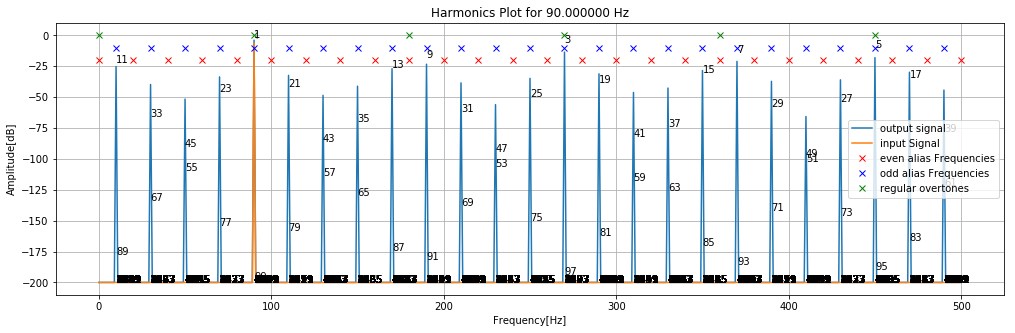

3.6241785764457495

In [46]:
inputOutputToAliasingRatio(f,testSig,dist,sr,roundTrips=roundTrips, doPlot=True)

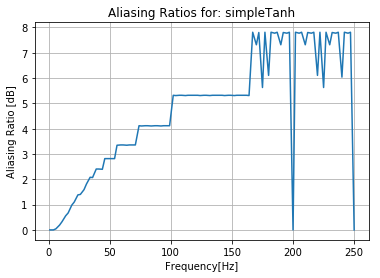

Average ratio: 4.777710


In [47]:
ratios = getAliasingRatioPerFreq(simpleTanh,sr,roundTrips=roundTrips)
print('Average ratio: %f'%np.average(ratios))

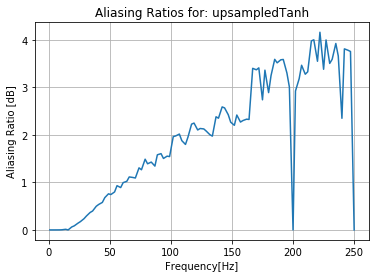

Average ratio: 1.968593


In [48]:
ratios = getAliasingRatioPerFreq(upsampledTanh,sr,roundTrips=roundTrips)
print('Average ratio: %f'%np.average(ratios))

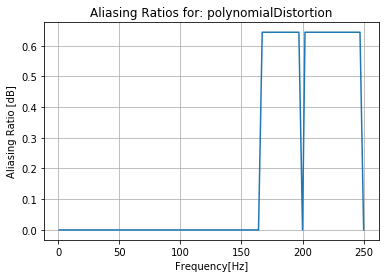

Average ratio: 0.205982


In [49]:
# plt.figure(figsize=[17,7])
ratios = getAliasingRatioPerFreq(polynomialDistortion,sr,roundTrips=roundTrips)
print('Average ratio: %f'%np.average(ratios))

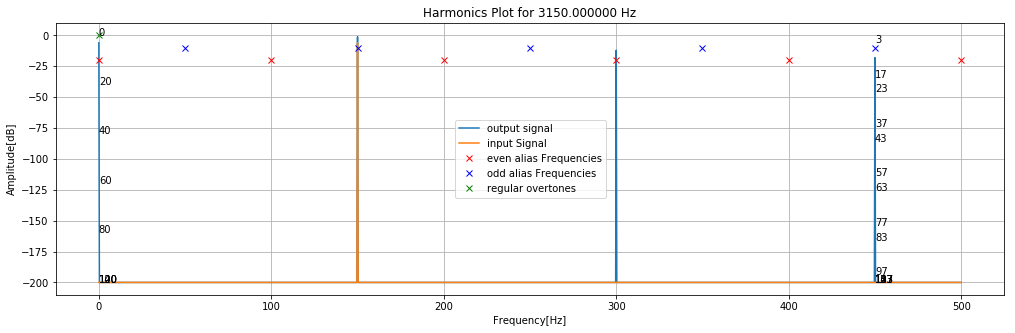

10.881360887005929

In [50]:
fundamentalToAliasingRatio(3150, polynomialDistortion,sr,roundTrips=roundTrips)

## Using Up-Sampling to measure Aliasing

In [51]:
def fundamentalToAliasingRatioViaUpsampling(f, testSystem, sr, resamplingFactor=32, T=3, doPlot=True):
    N = int(sr*T)
    n = np.arange(N)
    t = n/sr
    
    x = np.sin(2*np.pi*t*f)
#     N = len(x)
    y = testSystem(x)
    upsX = resample(x,N*resamplingFactor)
    upsY = testSystem(upsX)
    downsY = resample(upsY,N)
    
    specY, specDownsY, freqAxis = getSpec(y,downsY,sr)
    if doPlot:
        plt.figure(figsize=[17,7])
        plt.plot(freqAxis,aToDb(specY), label='regular')
        plt.plot(freqAxis, aToDb(specDownsY), label='upsampled')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    ratio = specY.sum()/specDownsY.sum()
    
    return aToDb(ratio)

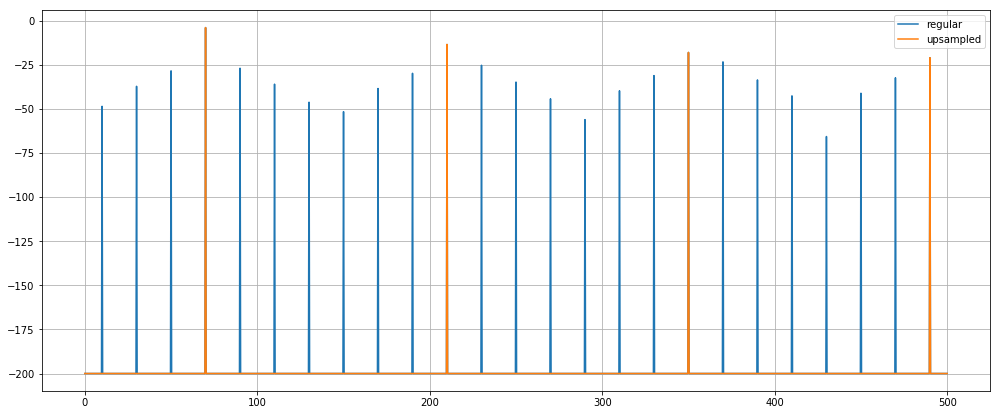

2.861828967586078

In [52]:
fundamentalToAliasingRatioViaUpsampling(70,simpleTanh,sr)

In [53]:
def getAliasingRatioPerFreqViaUpsampling(testFunction, sr, numTests=100, resamplingFactor=32, doPlot=True):
    ratios = np.zeros(numTests)
    
    freqs = np.linspace(sr/1000, sr/4, numTests)
    freqs = np.round(freqs)
    freqs = np.unique(freqs)
    
    for i in range(numTests):
        ratios[i] = fundamentalToAliasingRatioViaUpsampling(freqs[i], testFunction,sr, resamplingFactor=resamplingFactor, T=3,doPlot=False)
    if doPlot:
        plt.plot(freqs, ratios)
        plt.grid()
        plt.xlabel('Frequency[Hz]')
        plt.ylabel('Aliasing Ratio [dB]')
        plt.title('Aliasing Ratios for: '+testFunction.__name__)
        plt.show()
    
    return ratios
        

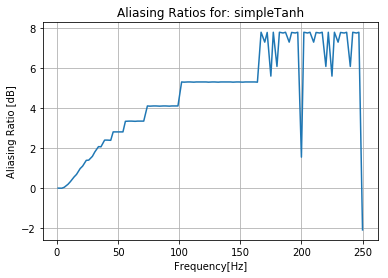

In [54]:
_=getAliasingRatioPerFreqViaUpsampling(simpleTanh,sr)

# Comparison
The two techniques produce nearly equal results.

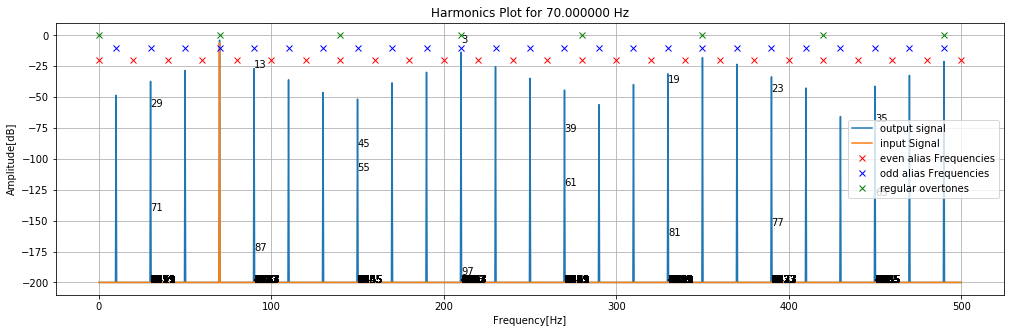

2.8667887343939387

In [55]:
fundamentalToAliasingRatio(70, simpleTanh,sr,roundTrips = 1000)

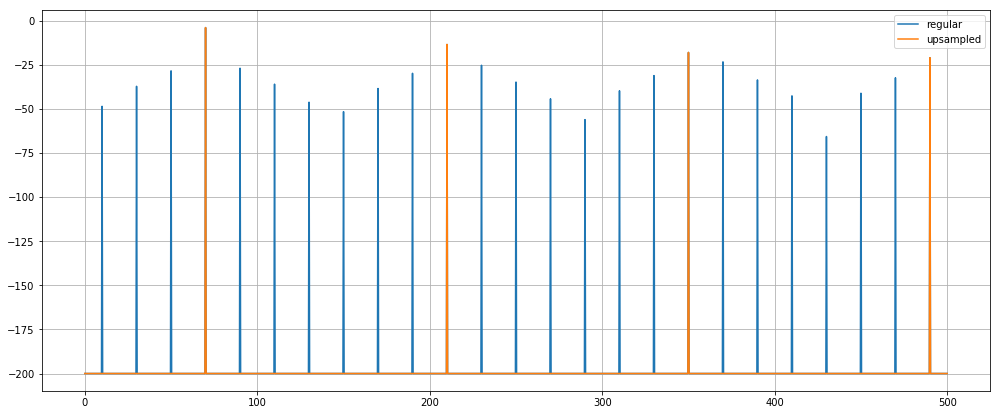

2.861828967586078

In [56]:
fundamentalToAliasingRatioViaUpsampling(70, simpleTanh,sr)

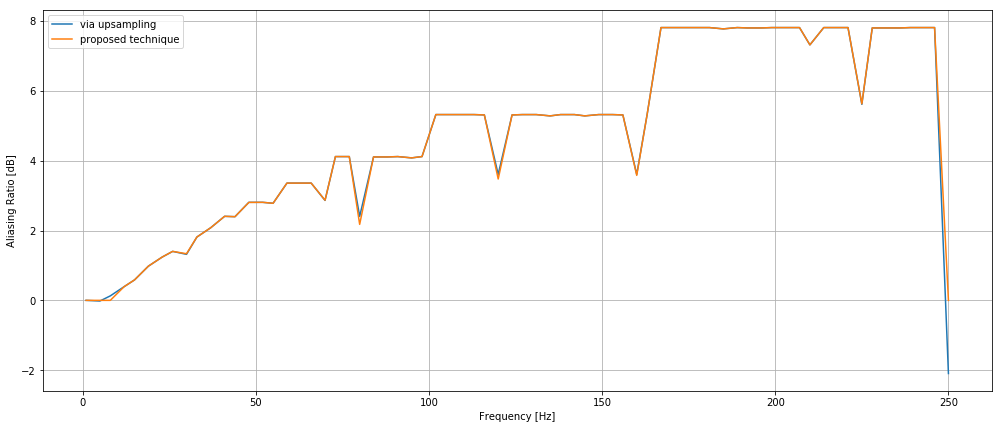

In [57]:
numTests = 70
upsRatios = getAliasingRatioPerFreqViaUpsampling(simpleTanh,sr,doPlot=False,resamplingFactor=128,numTests=numTests)
calcRatios = getAliasingRatioPerFreq(simpleTanh,sr,doPlot=False,roundTrips=1000,numTests=numTests)


plt.figure(figsize=[17,7])
freqs = np.linspace(sr/1000, sr/4, numTests)
freqs = np.round(freqs)
freqs = np.unique(freqs)
plt.plot(freqs,upsRatios, label='via upsampling')
plt.plot(freqs, calcRatios, label='proposed technique')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Aliasing Ratio [dB]')
plt.legend()
plt.grid()
plt.show()